# Agent-Based Kinetics via Topology (ABa-KiTo)
Date: 13.12.2025

In this notebook, I plot the simulation data in 4 Dimensions; i.e. x = time, y= Number of agents, z = Green Output share colored by their state chi value

In [39]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist
import pickle


import sys
import os
import torch as pt
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nbformat
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick



print("NumPy version:", np.__version__)
print("Torch version:", pt.__version__)


NumPy version: 1.26.4
Torch version: 2.3.0+cpu


In [2]:
# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..",'..'))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.modules_mokito import *


In [3]:
#Create results directory
path = os.path.join('ABa-KiTo', 'voter_dynamics_SW', 'data')
data_dir = os.path.join(project_root, path)

graphs_dir = os.path.join(data_dir, 'graphs_results')
os.makedirs(graphs_dir, exist_ok=True)
results_dir = graphs_dir

In [4]:
#Load data formatted from ABM simulations and ISOKANN.jl 

sims_path = os.path.join('ABa-KiTo', 'voter_dynamics_SW', 'data', 'simulations','')
data_dir =  os.path.join(project_root, sims_path)

# Read data
states_data = np.load(data_dir + '2025-11-18-data_VD_SW_3InteractingAgents.npz')
xs = states_data['xs'] #xs.shape (n_dim, n_samples)
ys = states_data['ys'] #ys-shape (n_dim, n_koop = 1, n_samples)

#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)
Xt = np.transpose(ys, (2, 1, 0))   # (n_samples, 1, n_dim)

# --- Log + Scale both X0 and Xt consistently ---
scaler = StandardScaler()

# X0
X0_log = np.log1p(X0)
X0_scaled = scaler.fit_transform(X0_log)   # (n_samples, n_dim)

# Xt: flatten for scaling
Xt_flat = Xt.reshape(-1, Xt.shape[2])      # (n_samples * n_koop, n_dim)
Xt_log = np.log1p(Xt_flat)
Xt_scaled = scaler.transform(Xt_log)
Xt_scaled = Xt_scaled.reshape(Xt.shape)    # (n_samples, 1, n_dim)


# # # --- Load chi function ---
chivals_path = os.path.join('ABa-KiTo', 'voter_dynamics_SW','data',  'chi_vals', '')
chivals_dir = os.path.join(project_root, chivals_path)
chi0 = np.load(chivals_dir + 'chi_values_VD_SW.npz')

# --- Organize for MoKiTo ---
data = OrganizeData(X0_scaled, Xt_scaled, chi0)





Check shape of input data
X0.shape   =  (200000, 202)
Xt.shape   =  (200000, 1, 202)
chi0.shape =  (200000,)
  


In [5]:
#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)

#Reshape data to account for time
n_time = 50
n_samples, n_dim = X0.shape
n_traj = n_samples // n_time

X_traj = X0.reshape(n_traj, n_time, n_dim)



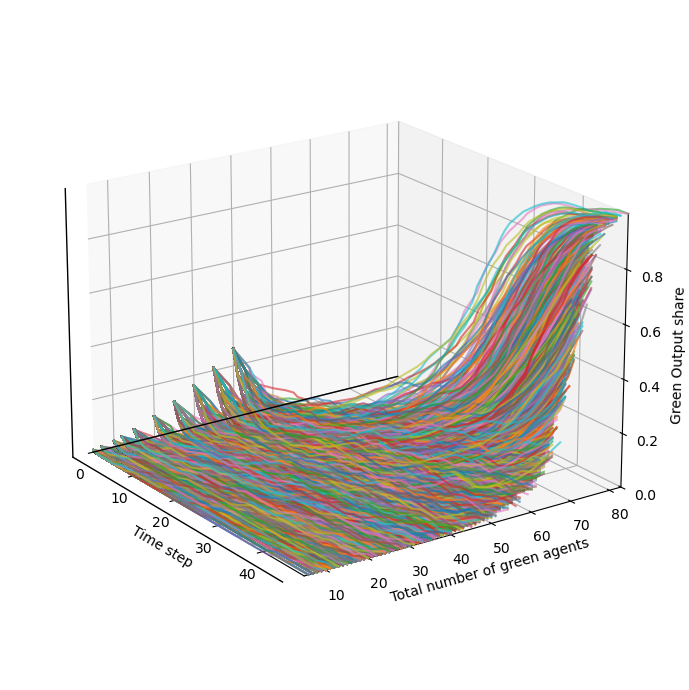

In [38]:
#3d trajectories
macro_traj = X_traj[:, :, -2:]   # shape (n_traj, 50, 2)
time = np.arange(n_time)
macro1 = "Total number of green agents"
macro2 = "Green Output share"

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_traj):
    ax.plot(
        time,                       # x = time
        macro_traj[i, :, 0],        # y = macro 1
        macro_traj[i, :, 1],        # z = macro 2
        alpha=0.6
    )

ax.set_xlabel("Time step")
ax.set_ylabel(macro1)
ax.set_zlabel(macro2)
ax.set_box_aspect(None, zoom=0.89)

# Axis limits (important!)
ax.set_xlim(time.min(), time.max())
ax.set_ylim(macro_traj[:, :, 0].min(), macro_traj[:, :, 0].max())
ax.set_zlim(macro_traj[:, :, 1].min(), macro_traj[:, :, 1].max())

# Zero reference lines
ax.plot(ax.get_xlim(), [0, 0], [0, 0], color='k', linewidth=1)  # x-axis
ax.plot([0, 0], ax.get_ylim(), [0, 0], color='k', linewidth=1)  # y-axis
ax.plot([0, 0], [0, 0], ax.get_zlim(), color='k', linewidth=1)  # z-axis

ax.azim = -35
ax.dist = 0
ax.elev = 20


plt.tight_layout()
#plt.show()
plt.savefig(f"{results_dir}/trajectories3D_VD_SW.png")

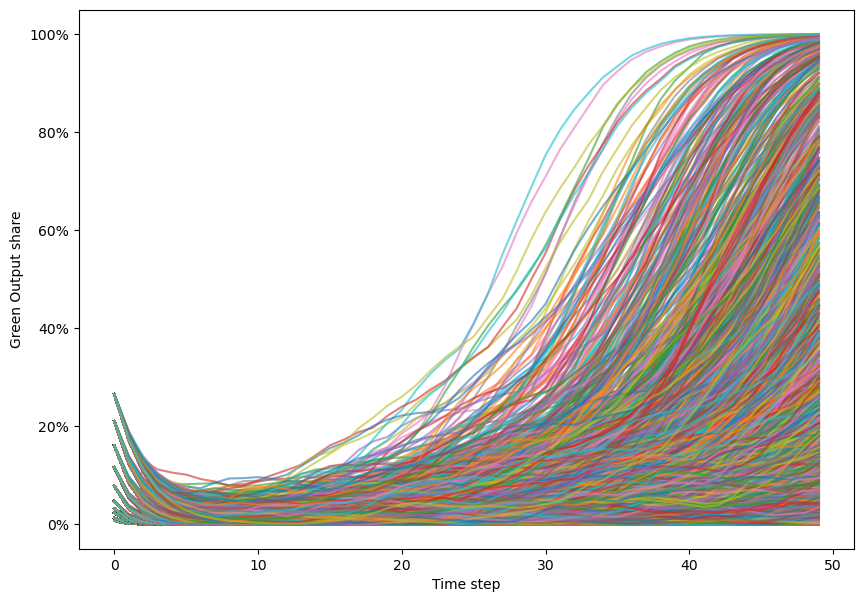

In [40]:
#2D plot

fig, ax = plt.subplots(figsize=(10, 7))

for i in range(n_traj):
    ax.plot(
        time,
        macro_traj[i, :, 1],   # already in %
        alpha=0.6
    )

ax.set_xlabel('Time step')
ax.set_ylabel(macro2)

# Format y-axis as percentage (no extra scaling)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.savefig(f"{results_dir}/trajectories_GOS_VD_SW.png")


In [7]:
# #3D trajectories using plotly for exploration

# fig = go.Figure()

# for i in range(n_traj):
#     fig.add_trace(go.Scatter3d(
#         x=time,
#         y=macro_traj[i, :, 0],
#         z=macro_traj[i, :, 1],
#         mode='lines',
#         opacity=1,
#         line=dict(width=5)
#     )
#     )

# # for i in range(n_traj):
# #     fig.add_trace(go.Scatter3d(
# #         x=macro_traj[i, :, 0],
# #         y=macro_traj[i, :, 1],
# #         z=time,
# #         mode='lines',
# #         opacity=0.6
# #     ))

# # Set camera
# camera = dict(
#     eye=dict(
#         x=np.cos(np.radians(-35)) * 2,   # azim equivalent
#         y=np.sin(np.radians(-35)) * 2,
#         z=0.5                         # elev equivalent
#     )
# )

# fig.update_layout(
#     scene_camera=camera,
#     margin=dict(l=0, r=0, t=0, b=1),
#     scene=dict(
#         xaxis=dict(title=dict(text="Time", font=dict(size=22)), tickfont=dict(size=16)),
#         yaxis=dict(title=dict(text=macro1, font=dict(size=22)), tickfont=dict(size=16)),
#         zaxis=dict(title=dict(text=macro2, font=dict(size=22)), tickfont=dict(size=16))
#     ),
#     legend=dict(
#         x=0.95,
#         y=0.65,
#         xanchor='right',
#         yanchor='top',
#         bgcolor='rgba(255,255,255,0.7)',
#         bordercolor='black',
#         borderwidth=1,
#         font=dict(size=22)
#     ),
#     width=1200,   # corresponds to 12 inches
#     height=1000,  # corresponds to 10 inches
#     showlegend=False
# )

# # fig.show()
# # fig.show(renderer="browser")

# import plotly.io as pio
# from PIL import Image
# import io

# # Convert figure to PNG in memory
# img_bytes = fig.to_image(format="png", width=1200, height=1000)
# img = Image.open(io.BytesIO(img_bytes))
# img.show()  # opens the default image viewer


# #fig.write_image("N4intervals_results/trajectories3D_VD_FC.png", width=1200, height=1000)


# # fig.update_layout(showlegend=False)

# # fig.show()
# # fig.show(renderer="browser")


In [9]:
# # to delete such that the figure doesn't take that much memory space
# del fig
# import gc
# gc.collect()


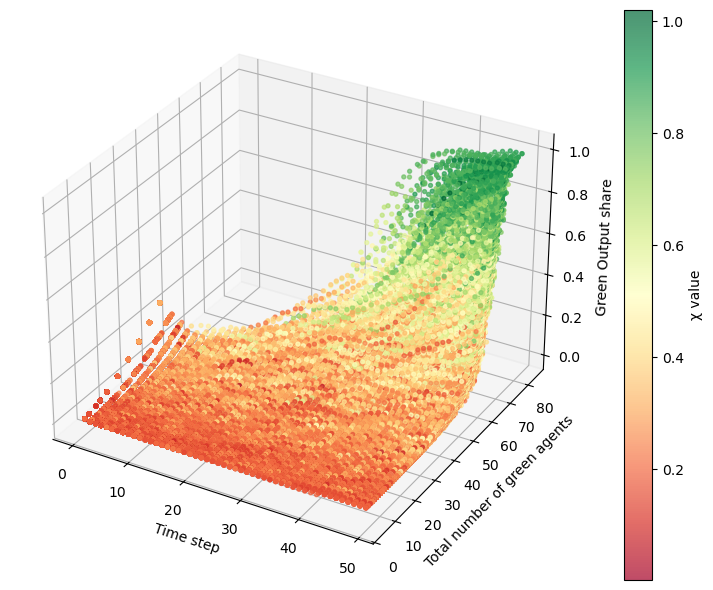

In [51]:
#Scatter plot colored by chi values

macro_flat = macro_traj.reshape(-1, 2)
time_flat = np.tile(time, n_traj)
cmap=plt.cm.RdYlGn


fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    time_flat,                 # x = time
    macro_flat[:, 0],          # y = macro 1
    macro_flat[:, 1],          # z = macro 2
    c=chi0,
    cmap=cmap,
    s=8,
    alpha=0.7,
    # vmin=0, vmax=1
)

cbar = plt.colorbar(sc)
cbar.set_label("χ value")

ax.set_xlabel("Time step")
ax.set_ylabel(macro1)
ax.set_zlabel(macro2)

plt.tight_layout()
#plt.show()
plt.savefig(f"{results_dir}/Scatter_plot_3D_byChi_vals_VD_SW.png")

In [ ]:
# import plotly.graph_objects as go

# macro_flat = macro_traj.reshape(-1, 2)
# time_flat = np.tile(time, n_traj)

# fig = go.Figure()

# fig.add_trace(go.Scatter3d(
#     x=time_flat,                # time
#     y=macro_flat[:, 0],         # macro 1
#     z=macro_flat[:, 1],         # macro 2
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=chi0,             # color values
#         colorscale='RdYlGn',    # Plotly colorscale (string!)
#         cmin=0,
#         cmax=1,
#         opacity=0.7,
#         colorbar=dict(title="χ value")
#     )
# ))

# fig.update_layout(
#     showlegend=False,
#     scene=dict(
#         xaxis_title="Time",
#         yaxis_title=macro1,
#         zaxis_title=macro2,
#         # xaxis=dict(showbackground=False),
#         # yaxis=dict(showbackground=False),
#         # zaxis=dict(showbackground=False),
#     ),
#     width=800,
#     height=600
# )

# fig.show()


In [42]:
#Reload clustering results:
# Load the specific run you want to use (Nintervals=5, seed=42 for example)
clustering_dir = os.path.join( "..", 'data', 'clustering_results')
n_intervals = 3
seed = 123
with open(f'{clustering_dir}/Nint{n_intervals}_seed{seed}_FNs.pkl', 'rb') as f:
    FNs = pickle.load(f)

with open(f'{clustering_dir}/Nint{n_intervals}_seed{seed}_FCs.pkl', 'rb') as f:
    FIs = pickle.load(f)

In [43]:
#Clustering results
noise_pct = np.sum(FNs.nodes == -1) / len(FNs.nodes) * 100
print(f"Result: {FNs.Nnodes} clusters, {noise_pct:.1f}% noise\n\n")
print(f"Cluster sizes - min: {FNs.nodes_size.min()}, max: {FNs.nodes_size.max()}, median: {np.median(FNs.nodes_size):.0f}")
print(f"Clusters per interval: {[np.sum(FNs.index_chi_node == i) for i in range(FIs.Nintervals)]}\n")

for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

Result: 13 clusters, 7.5% noise


Cluster sizes - min: 57, max: 76944, median: 561
Clusters per interval: [2, 2, 9]

Node, interval, size: 0 0 27556
Node, interval, size: 1 0 76944
Node, interval, size: 2 1 67053
Node, interval, size: 3 1 561
Node, interval, size: 4 2 620
Node, interval, size: 5 2 111
Node, interval, size: 6 2 82
Node, interval, size: 7 2 64
Node, interval, size: 8 2 111
Node, interval, size: 9 2 750
Node, interval, size: 10 2 57
Node, interval, size: 11 2 10962
Node, interval, size: 12 2 116


In [10]:
cluster_labels = FNs.nodes        # shape (n_samples,)

print(cluster_labels.shape)   # should be (n_samples,)
print(np.unique(cluster_labels))


(200000,)
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


In [11]:
#to handle noise
is_noise = cluster_labels == -1
is_clustered = ~is_noise


In [45]:
# Scatter plot colored by cluster
# Example categorical palette for 10 clusters (Vivid-like)
colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231",
    "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe",
    "#4d4d4d",  # dark gray instead of black
    "#d26e33",  # brown / earth tone
    "#35c097",   # dark teal
    "#6666ff"  # medium periwinkle / blue-violet

]


n_clusters = len(np.unique(cluster_labels[is_clustered]))
if n_clusters > len(colors):
    raise ValueError("You need more colors for your number of clusters!")

fig = go.Figure()

for k, color in zip(np.unique(cluster_labels[is_clustered]), colors):
    mask = cluster_labels[is_clustered] == k
    fig.add_trace(go.Scatter3d(
        x=time_flat[is_clustered][mask],
        y=macro_flat[is_clustered, 0][mask],
        z=macro_flat[is_clustered, 1][mask],
        mode='markers',
        marker=dict(
            size=8,
            color=color,
            opacity=0.8
        ),
        name=f"Cluster {k}",
        showlegend=False
    ))

    # Legend-only trace (big marker)
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='markers',
        marker=dict(size=14, color=color),
        name=f"Cluster {k}",
        showlegend=False
    ))


# Set camera
camera = dict(
    eye=dict(
        x=np.cos(np.radians(-35)) * 2,   # azim equivalent
        y=np.sin(np.radians(-35)) * 2,
        z=1.5                           # elev equivalent
    )
)

fig.update_layout(
    scene_camera=camera,
    margin=dict(l=0, r=0, t=0, b=0),
    scene=dict(
        xaxis=dict(title=dict(text="Time step", font=dict(size=22)), tickfont=dict(size=16)),
        yaxis=dict(title=dict(text=macro1, font=dict(size=22)), tickfont=dict(size=16)),
        zaxis=dict(title=dict(text=macro2, font=dict(size=22)), tickfont=dict(size=16))
    ),
    legend=dict(
        x=0.95,
        y=0.65,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=25)
    ),
    width=1200,   # corresponds to 12 inches
    height=1000,  # corresponds to 10 inches
    showlegend=True
)

# fig.show()
# fig.show(renderer="browser")

import plotly.io as pio
from PIL import Image
import io

# Convert figure to PNG in memory
img_bytes = fig.to_image(format="png", width=1200, height=1000)
img = Image.open(io.BytesIO(img_bytes))
img.show()  # opens the default image viewer


fig.write_image(f"{results_dir}/scatter3d_color_by_clusters_VD_SW.png", width=1200, height=1000)


In [14]:
del fig
import gc
gc.collect()


937

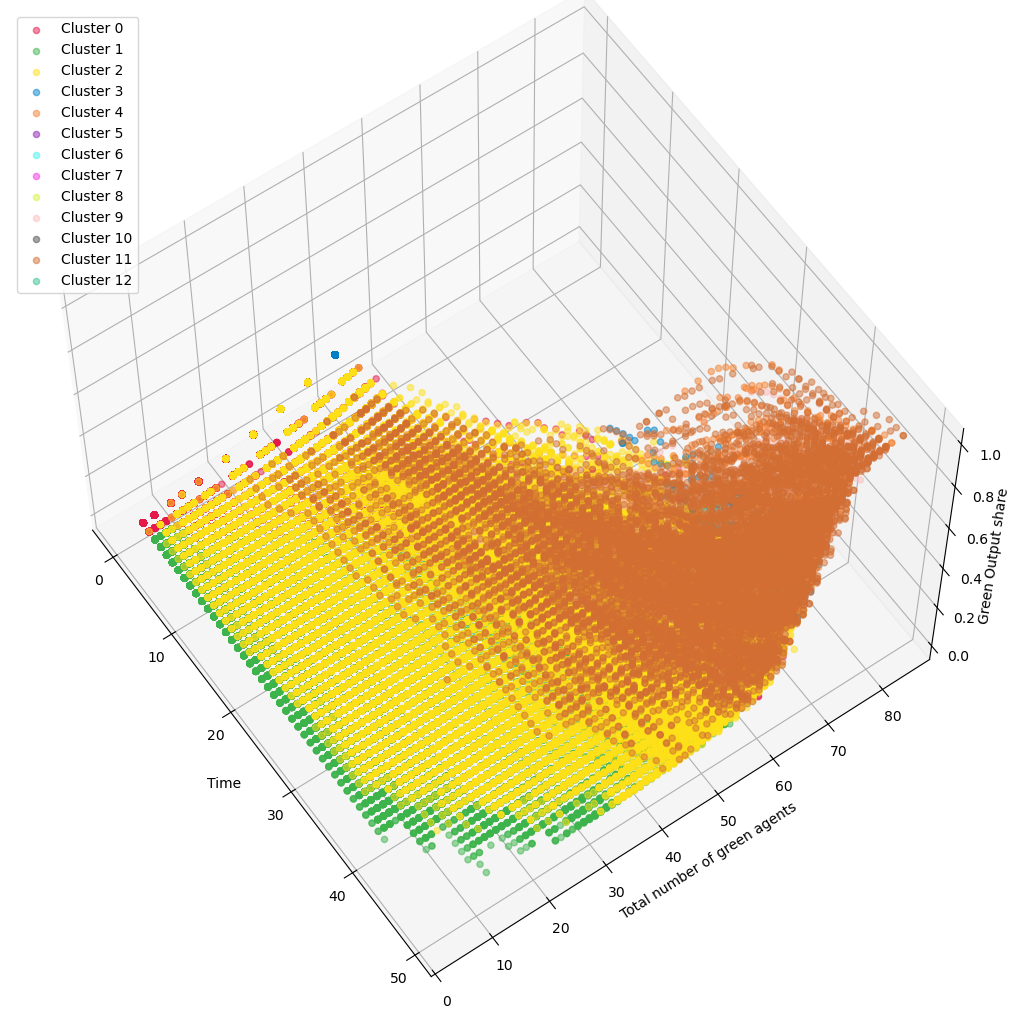

In [46]:
#Scatter plot coloured by cluster

# Example categorical palette for 10 clusters (Vivid-like)
colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231",
    "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe",
    "#4d4d4d",  # dark gray instead of black
    "#d26e33",  # brown / earth tone
    "#35c097",   # dark teal
    "#6666ff"  # medium periwinkle / blue-violet

]

n_clusters = len(np.unique(cluster_labels[is_clustered]))
if n_clusters > len(colors):
    raise ValueError("You need more colors for your number of clusters!")

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for k, color in zip(np.unique(cluster_labels[is_clustered]), colors):
    mask = cluster_labels[is_clustered] == k
    ax.scatter(
        time_flat[is_clustered][mask],      # x-axis = Time
        macro_flat[is_clustered, 0][mask], # y-axis = Macro 1
        macro_flat[is_clustered, 1][mask], # z-axis = Macro 2
        c=color,
        label=f"Cluster {k}",
        s=20,
        alpha=0.5
    )

# # Optional: plot noise points
# ax.scatter(
#     time_flat[is_noise],
#     macro_flat[is_noise, 0],
#     macro_flat[is_noise, 1],
#     c='lightgray',
#     s=10,
#     alpha=0.3,
#     label='Noise'
# )

# Axis labels
ax.set_xlabel("Time")
ax.set_ylabel(macro1)
ax.set_zlabel(macro2, labelpad=-1)
ax.zaxis.label.set_rotation(0)  



# Legend
ax.legend(loc='upper left')

ax.azim = -35
ax.dist = 0
ax.elev = 60

plt.tight_layout()
plt.show()



In [ ]:
# #Color by average chi-value
# chi_nodes  = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)

# #flatten chi nodes
# chi_nodes_flat = chi_nodes.ravel()   # shape (n_nodes,)

# #map state to node
# chi_per_state = np.full(cluster_labels.shape, np.nan, dtype=float)
# chi_per_state[is_clustered] = chi_nodes_flat[cluster_labels[is_clustered]]

# fig = go.Figure()

# fig.add_trace(go.Scatter3d(
#     x=time_flat[is_clustered],
#     y=macro_flat[is_clustered, 0],
#     z=macro_flat[is_clustered, 1],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=chi_per_state[is_clustered],
#         colorscale='RdYlGn',
#         cmin=0,
#         cmax=1,
#         opacity=0.7,
#         colorbar=dict(title="Cluster χ")
#     )
# ))

# fig.show()




In [ ]:
del fig
import gc
gc.collect()

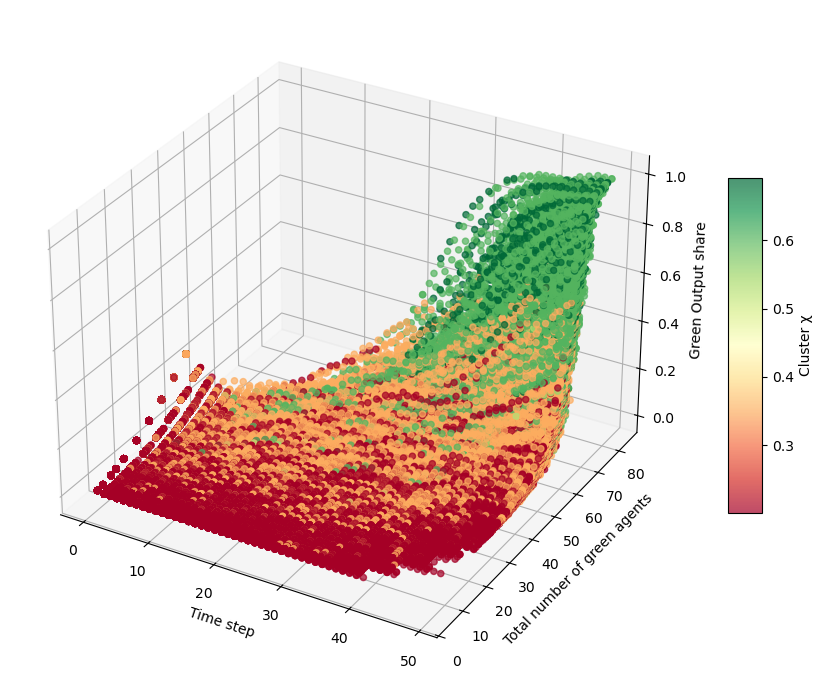

In [47]:
# Create figure and 3D axes Colored by average chi-value
chi_nodes  = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)

#flatten chi nodes
chi_nodes_flat = chi_nodes.ravel()   # shape (n_nodes,)

#map state to node
chi_per_state = np.full(cluster_labels.shape, np.nan, dtype=float)
chi_per_state[is_clustered] = chi_nodes_flat[cluster_labels[is_clustered]]


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot colored by chi_per_state
p = ax.scatter(
    time_flat[is_clustered],           # x-axis = time
    macro_flat[is_clustered, 0],       # y-axis = macro 1
    macro_flat[is_clustered, 1],       # z-axis = macro 2
    c=chi_per_state[is_clustered],     # color = cluster χ
    cmap='RdYlGn',                     # colormap
    s=20,                              # marker size
    alpha=0.7
)

# Add colorbar
cbar = fig.colorbar(p, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster χ")

# Axis labels
ax.set_xlabel("Time step")
ax.set_ylabel(macro1)
ax.set_zlabel(macro2)

plt.tight_layout()
plt.show()

In [ ]:
#BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=100, threshold =1, algorithm='mlp')

100%|██████████| 200000/200000 [00:20<00:00, 9730.54it/s] 


In [28]:
# import pickle

# #Save the BAM object
# with open('BAM_object_N4.pkl', 'wb') as f:
#     pickle.dump(BAM, f)

In [ ]:
# import pickle
# with open('BAM_object_N3.pkl', 'rb') as f:
#     BAM = pickle.load(f)

In [48]:
BAM.A

array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]])

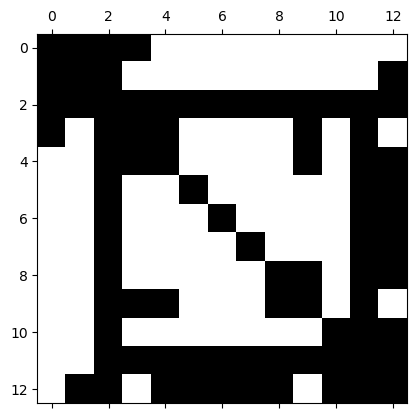

In [49]:
BG     =  BuildGraph(FNs, BAM)
G      =  BG.G

plt.spy(BAM.A) #show the sparsity pattern of a matrix.

In [22]:
chi_nodes  = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)
# gradient_chi_nodes = np.zeros((FNs.Nnodes,FNs.Nnodes))

# for i in range(FNs.Nnodes):
#     for j in range(FNs.Nnodes):
#          gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]

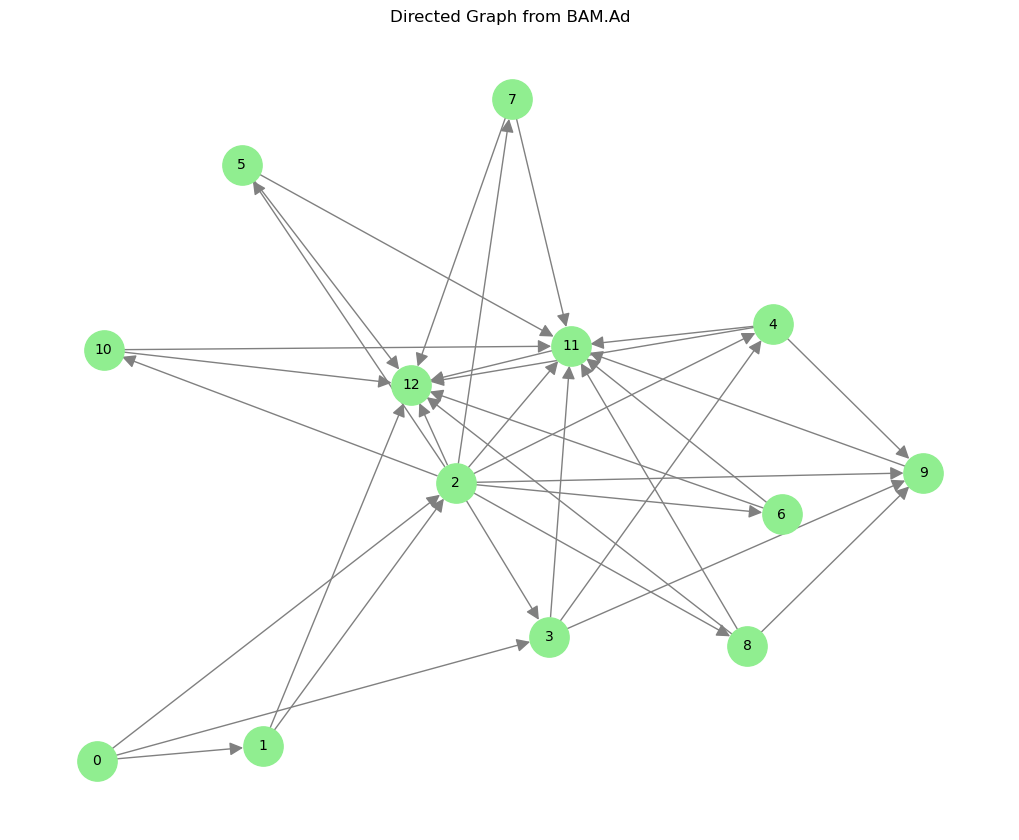

In [24]:
A = BAM.Ad.T
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

plt.figure(figsize=(10, 8))
#pos1 = nx.kamada_kawai_layout(G)  # or spring_layout, circular_layout, etc.
#pos1 = nx.kamada_kawai_layout(BG.G)
pos1 = nx.spring_layout(BG.G, seed=32)
# Rotate 180 degrees
pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightgreen',
    edge_color='gray',
    node_size=800,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>',
    font_size=10
)

plt.title("Directed Graph from BAM.Ad")
plt.show()

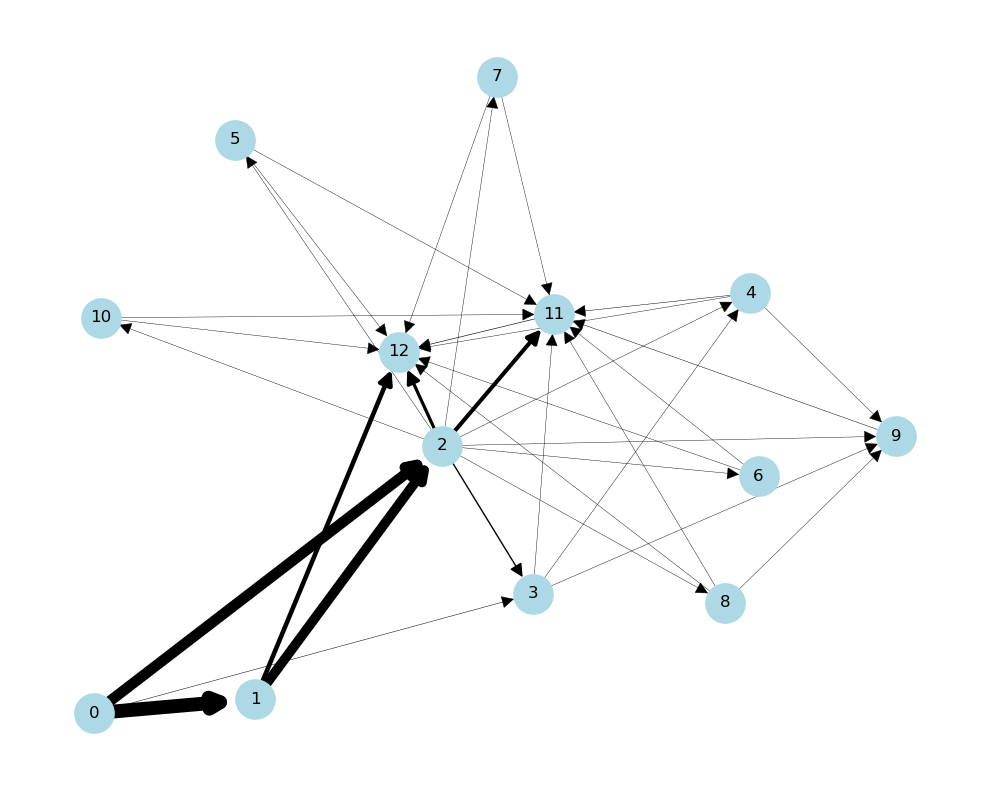

In [25]:
# Create directed graph with weights from C but directionality from Ad.T
Gd = nx.DiGraph()

for i in range(BAM.Ad.T.shape[0]):
    for j in range(BAM.Ad.T.shape[1]):
        if BAM.Ad.T[i, j] > 0:  # Only add edge if it exists in Ad (unidirectional)
            Gd.add_edge(i, j, weight=BAM.C[i, j])  # Use weight from C

# Extract weights
edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# Normalize with minimum width
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [10 * (w / max_weight) for w in edge_weights]
min_width = 0.3
edge_widths = [max(w, min_width) for w in edge_widths]

plt.figure(figsize=(10, 8))
# pos1 = nx.kamada_kawai_layout(BG.G)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Draw edges
nx.draw_networkx_edges(Gd, pos,
                       width=edge_widths,
                       arrowstyle='-|>',
                       arrowsize=20,
                       edge_color='black',
                       node_size=800)

# Draw nodes
nx.draw_networkx_nodes(Gd, pos,
                       node_size=800,
                       node_color='lightblue')

# Draw labels
nx.draw_networkx_labels(Gd, pos,
                        font_size=12,
                        font_color='black')

plt.axis('off')
plt.tight_layout()
plt.show()

Number of paths found: 50
Best path weight: 6570.0
Best path: [12, 11, 2, 1, 0]
Found 50 paths

Top 5 paths:
Path 1: [12, 11, 2, 1, 0]
Path 2: [12, 2, 1, 0]
Path 3: [12, 11, 9, 4, 3, 2, 1, 0]
Path 4: [12, 11, 4, 3, 2, 1, 0]
Path 5: [12, 11, 9, 3, 2, 1, 0]


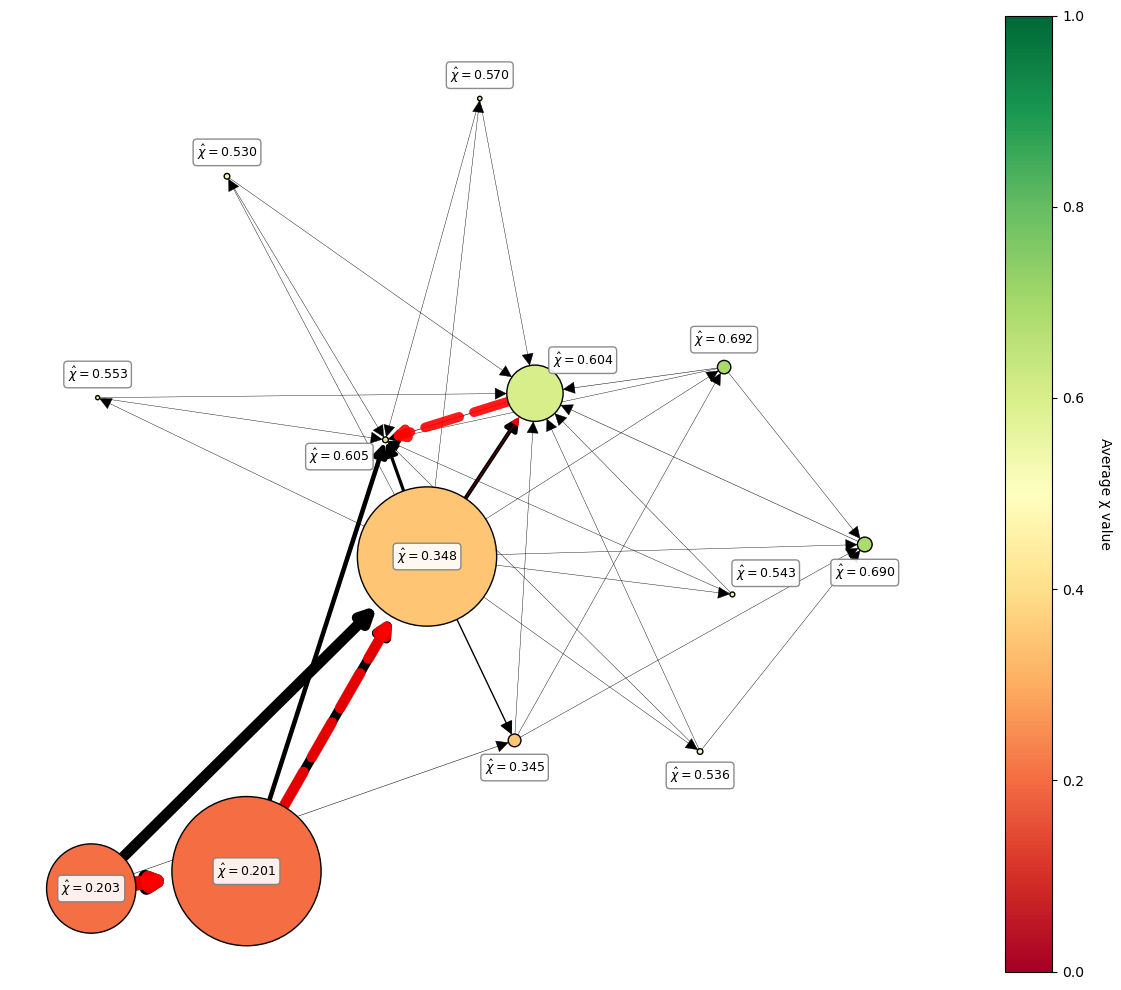

In [26]:
# # Create directed graph with weights from C but directionality from Ad.T 
## Node size is given by cluster size and nodes are colored by average chi value in the cluster
## graph is labelled by their chi value

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

# # Extract weights directly from the directed graph edges
# edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# # Normalize but enforce minimum width
# max_weight = max(edge_weights)
# edge_widths = [10 * (w / max_weight) for w in edge_weights]

# # Ensure minimum width of 0.5
# min_width = 0.5
# edge_widths = [max(w, min_width) for w in edge_widths]

fig, ax = plt.subplots(figsize=(12, 10))

# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

nx.draw_networkx_edges(Gd, pos, edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=edge_widths,#[w*0.9 for w in edge_widths],
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: f"{n}" for n in BG.G.nodes()}
chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
#chi_labels = {n: f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}

#Convert node sizes to dictionary
if isinstance(node_sizes_scaled, list):
    node_size_dict = {node: node_sizes_scaled[i] for i, node in enumerate(Gd.nodes())}
else:
    node_size_dict = node_sizes_scaled

scale_factor = 0.0015
padding = 0.05

label_pos = {}

# Manual overrides for specific nodes (adjust as needed)
manual_offsets = {
    # node_id: (x_offset, y_offset) in multiples of total_offset
    # Example: 3: (1.5, 0.5) means shift right and slightly up
     0:(0,0),
    1: (0,0),
    2: (0,0),
    6: (1.4, 0.9),
    11:(1,0.7),
    12: (-1.9, -0.7)
    }

for node, (x, y) in pos.items():
    node_radius = np.sqrt(node_size_dict[node]) * scale_factor
    total_offset = node_radius + padding
    
    if node in manual_offsets:
        # Use manual override
        x_mult, y_mult = manual_offsets[node]
        label_pos[node] = (x + total_offset * x_mult, y + total_offset * y_mult)
    else:
        # Use automatic placement
        if y > 0:
            label_pos[node] = (x, y + total_offset)
        else:
            label_pos[node] = (x, y - total_offset)

nx.draw_networkx_labels(Gd, label_pos, labels=chi_labels, 
                       font_size=9, ax=ax,
                       bbox=dict(boxstyle="round,pad=0.3",
                                facecolor='white',
                                edgecolor='gray',
                                alpha=0.9))








# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

#plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
#plt.savefig(f"{results_dir}/graph_with_most_probable_path_and_mean_chi_val_all_labels_VD_SW.pdf",bbox_inches='tight')

Number of paths found: 50
Best path weight: 6570.0
Best path: [12, 11, 2, 1, 0]


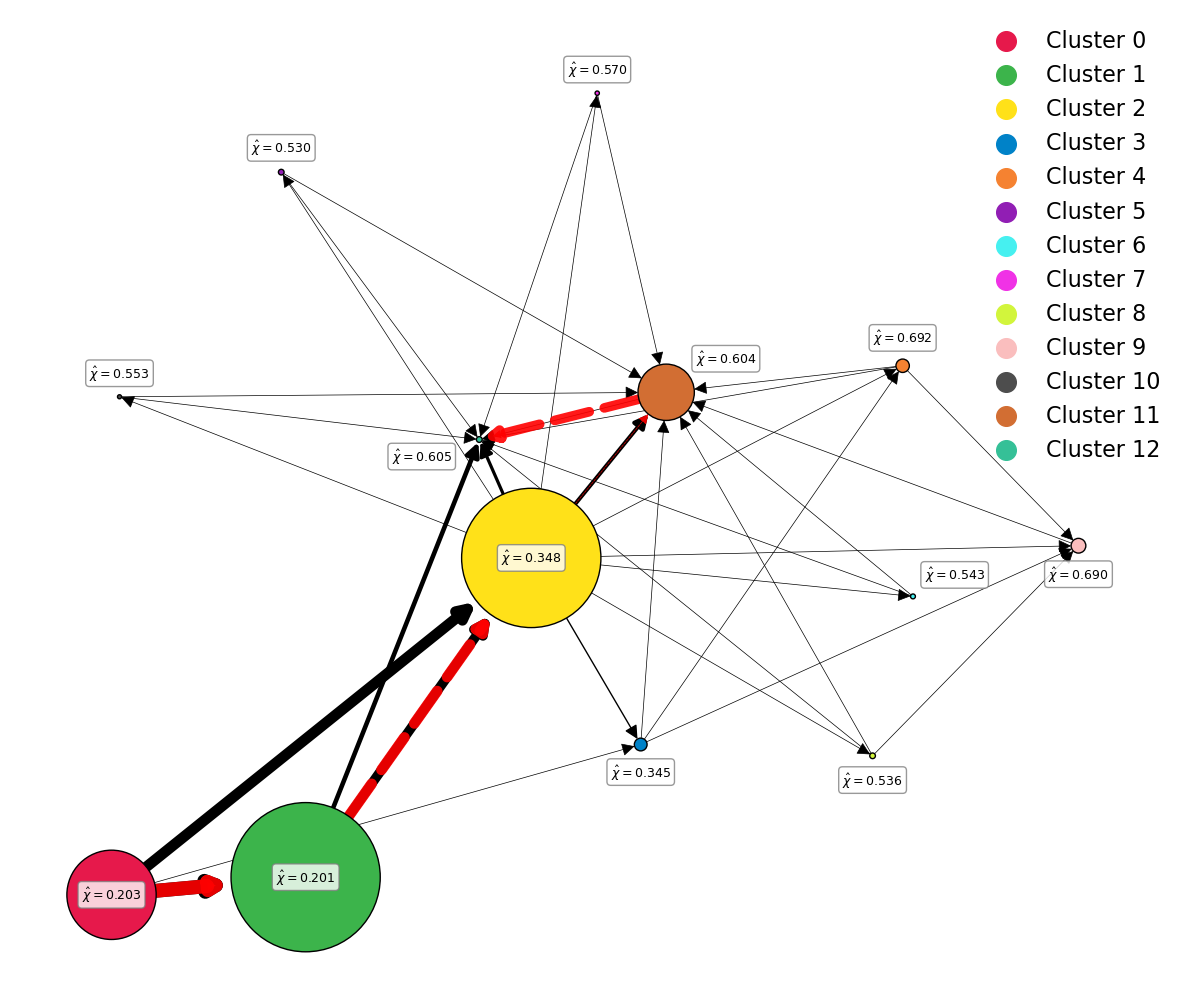

In [32]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

# --- 1. Prepare cluster colors ---
cluster_colors = colors

n_clusters = FNs.Nnodes  # total clusters
if n_clusters > len(cluster_colors):
    raise ValueError("Not enough colors for the number of clusters!")

# Ensure you have per-node cluster labels as integers 0..Nnodes-1
cluster_labels_per_node = np.unique(cluster_labels)#np.array(FNs.nodes)  # shape: (n_nodes,)
# Map nodes to colors
node_colors = [cluster_colors[cluster_labels_per_node[n+1]] for n in BG.G.nodes()]


# --- 2. Node sizes ---
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust scaling factor

# --- 3. Find paths ---
FP = FindPaths(FNs, BG, BAM, cutoff=10)
best_path = FP.list_paths[0]

# --- 4. Create figure ---
fig, ax = plt.subplots(figsize=(12, 10))

# --- 5. Draw edges ---
nx.draw_networkx_edges(
    Gd,
    pos,
    width=edge_widths,
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>',
    node_size=node_sizes_scaled,

)

# Highlight most probable path
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

nx.draw_networkx_edges(
    Gd,
    pos,
    edgelist=path_edges_flipped,
    edge_color='red',
    style='--',
    width=edge_widths,
    alpha=0.9,
    arrows=True,
    arrowsize=15,
    arrowstyle='-|>',
    ax=ax,
    node_size=node_sizes_scaled,
)

# --- 6. Draw nodes colored by cluster ---
nx.draw_networkx_nodes(
    Gd,
    pos,
    node_color=node_colors,
    node_size=node_sizes_scaled,
    edgecolors='black',
    ax=ax
)

# --- 7. Draw node labels showing average chi ---
chi_labels = {n: r"$\hat{\chi}=$" + f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}

# Compute label positions (using previous scale and padding)
node_size_dict = {node: node_sizes_scaled[i] for i, node in enumerate(Gd.nodes())}
scale_factor = 0.0015
padding = 0.05
label_pos = {}

manual_offsets = {
     0:(0,0),
    1: (0,0),
    2: (0,0),
    6: (1.4, 0.9),
    11:(1,0.7),
    12: (-1.9, -0.7)
    }

for node, (x, y) in pos.items():
    node_radius = np.sqrt(node_size_dict[node]) * scale_factor
    total_offset = node_radius + padding
    if node in manual_offsets:
        x_mult, y_mult = manual_offsets[node]
        label_pos[node] = (x + total_offset * x_mult, y + total_offset * y_mult)
    else:
        label_pos[node] = (x, y + total_offset if y > 0 else y - total_offset)

nx.draw_networkx_labels(
    Gd,
    label_pos,
    labels=chi_labels,
    font_size=9,
    ax=ax,
    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.8)
)

# --- 8. Add cluster legend ---
for k, color in enumerate(cluster_colors[:n_clusters]):
    ax.scatter([], [], c=color, label=f"Cluster {k}", s=200)
ax.legend(fontsize=16, frameon=False)

# --- 9. Finalize plot ---
plt.axis('off')
plt.tight_layout()
os.makedirs('graph_results', exist_ok=True)
plt.savefig(f"{results_dir}/graph_with_clusters_and_paths_col_cluster_VD_SW.pdf", bbox_inches='tight')
plt.show()


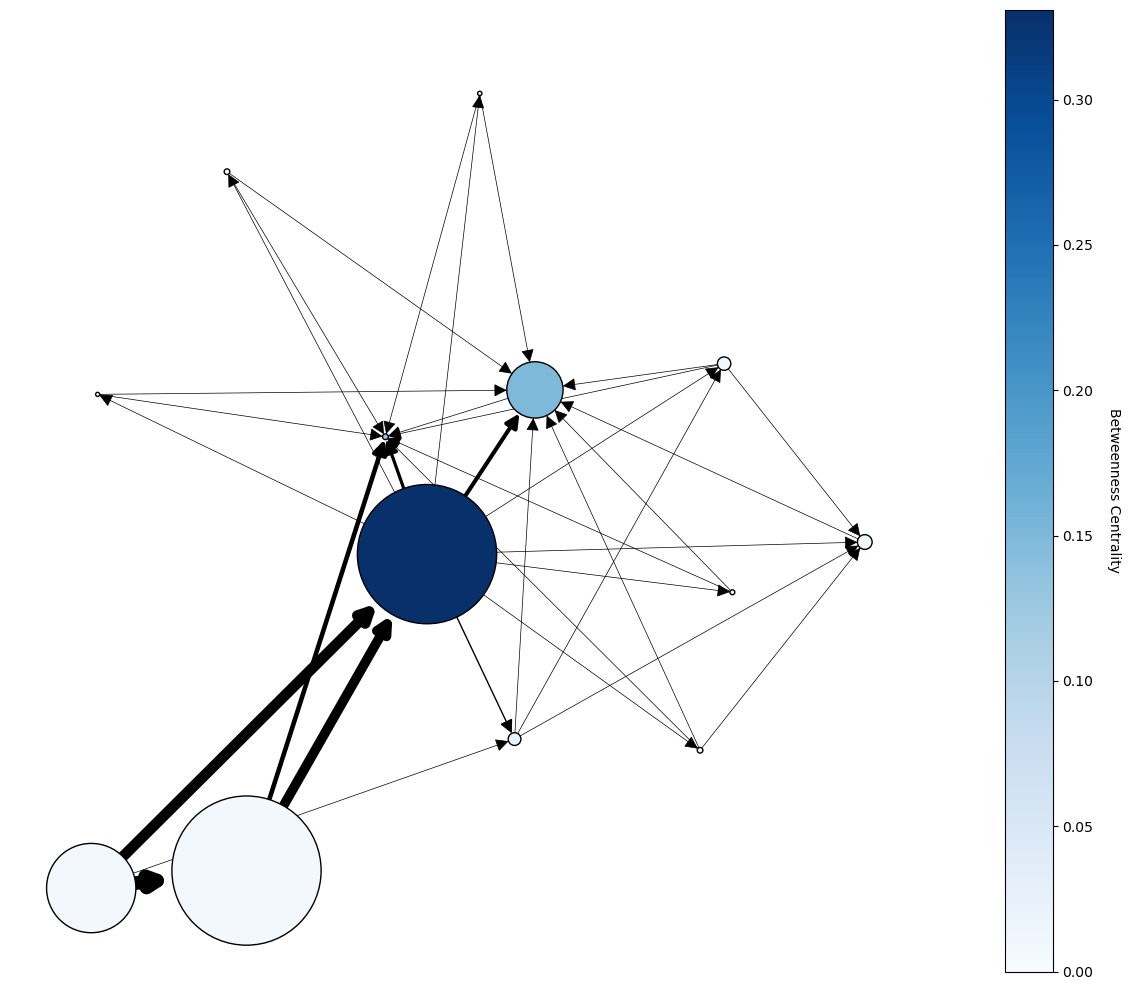

In [31]:
# Visualize Bottlenecks
# Calculate betweenness
betweenness = nx.betweenness_centrality(BG.G, weight='weight')

# Calculate flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

# Calculate flow through each edge
edge_flows = []
for u, v in BG.G.edges():
    if BG.G.has_edge(u, v):
        # Get the weight/flow from the edge attributes
        flow = BG.G[u][v].get('weight', 1)  # Default to 1 if no weight
        edge_flows.append(flow)

# Extract weights directly from the directed graph edges
edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# Normalize but enforce minimum width
max_weight = max(edge_weights)
edge_widths = [10 * (w / max_weight) for w in edge_weights]

# Ensure minimum width of 0.5
min_width = 0.5
edge_widths = [max(w, min_width) for w in edge_widths]

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))

# Color by betweenness (bottleneck measure)
node_colors = [betweenness[n] for n in BG.G.nodes()]

# --- 2. Node sizes ---
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust scaling factor

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

nx.draw_networkx_nodes(Gd, pos, edgecolors ='black', 
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=plt.cm.Blues,#Reds,
                       vmin=min(node_colors),
                       vmax=max(node_colors),
                       ax=ax)

# chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
# nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
#                        font_size=12, ax=ax)



sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,#Reds, 
                           norm=plt.Normalize(vmin=min(node_colors),#0.2, 
                                              vmax=max(node_colors)
                                              ))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Betweenness Centrality', rotation=270, labelpad=20)

plt.axis('off')
plt.tight_layout()

plt.savefig(f"{results_dir}/graph_betweeness_VD_SW.pdf")